In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import column_generation
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt

In [214]:
df = pd.read_csv('datasets/bupa.data',header=None)

In [215]:
df

,0,1,2,3,4,5,6
0,85,92,45,27,31,0.0,1
1,85,64,59,32,23,0.0,2
2,86,54,33,16,54,0.0,2
3,91,78,34,24,36,0.0,2
4,87,70,12,28,10,0.0,2
...,...,...,...,...,...,...,...
340,99,75,26,24,41,12.0,1
341,96,69,53,43,203,12.0,2
342,98,77,55,35,89,15.0,1
343,91,68,27,26,14,16.0,1


In [245]:
df[6].value_counts()

2    200
1    145
Name: 6, dtype: int64

In [250]:
y = df[6].apply(lambda x: 1 if x=='2' else -1).values
X = df.values[:,:6]

In [251]:
X

array([[85., 92., 45., 27., 31.,  0.],
       [85., 64., 59., 32., 23.,  0.],
       [86., 54., 33., 16., 54.,  0.],
       ...,
       [98., 77., 55., 35., 89., 15.],
       [91., 68., 27., 26., 14., 16.],
       [98., 99., 57., 45., 65., 20.]])

In [252]:
#X = MinMaxScaler().fit_transform(X)

In [263]:
lambda_star, F, soglie = column_generation.column_generation(X, y, C=1e3)

iteration 0----------------------------------------------------------------------------------------------------
                                     CVXPY                                     
                                     v1.3.1                                    
(CVXPY) Mar 25 07:17:59 PM: Your problem has 345 variables, 15 constraints, and 0 parameters.
(CVXPY) Mar 25 07:17:59 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 25 07:17:59 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 25 07:17:59 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 25 07:17:59 PM: Compiling problem (tar

In [236]:
# lambda_star = np.array([0 if l < 1e-6 else l for l in lambda_star])

In [237]:
omega_star = {}

for l in soglie.keys():
    omega_star[l] = np.zeros(len(soglie[l]))
    for b, phi in enumerate(soglie[l]):
        for i in range(len(X)):
            c = 1 if X[i,l] > phi else -1
            omega_star[l][b] += lambda_star[i] * c


In [238]:
def score_function(x):
    sum_ = 0
    n_predictor_vars = len(soglie)
    for l in range(n_predictor_vars):
        for j, b in enumerate(soglie[l]):
            if x[l] >= b:
                sum_ += omega_star[l][j]

    score = sum_ #+ B
    # print(score)
    if score > 0:
        return 1
    else:
        return -1


In [239]:
def predict(x):
    return np.array(list(map(score_function, x)))

In [240]:
y_pred = predict(X)

In [241]:
accuracy_score(y, y_pred)

0.043478260869565216

[0.6578947368421051] [1.2340282930340645e-13]


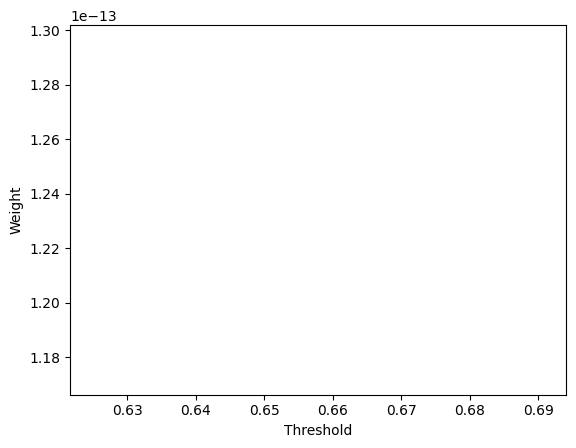

[0.38260869565217387] [1.1537207066144037e-13]


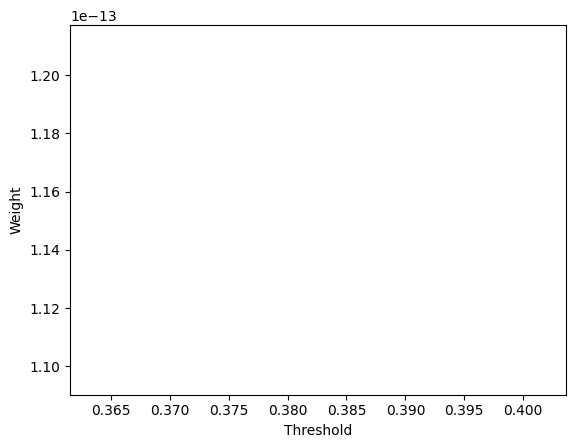

[0.1456953642384106] [2.028483816767675e-13]


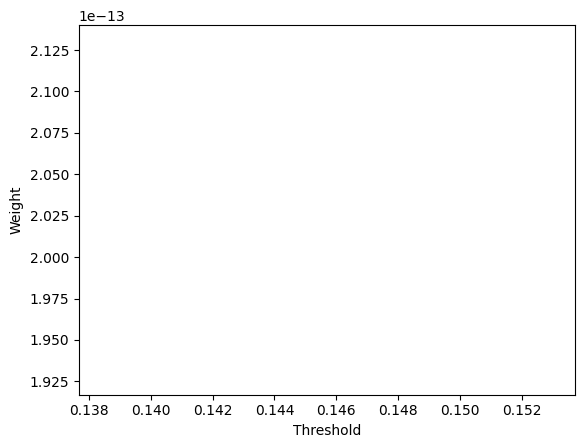

[0.2337662337662338] [3.7613780461136914e-13]


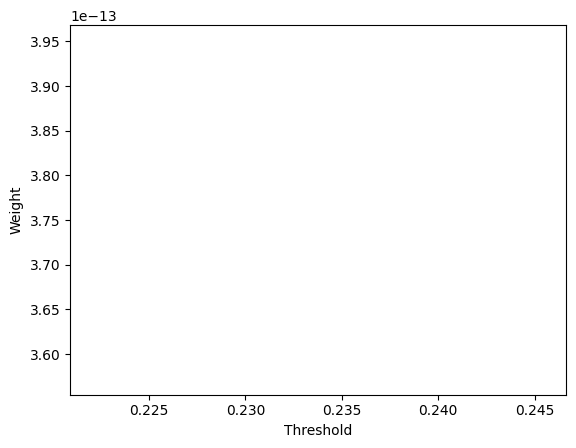

[0.0684931506849315] [5.953918509483222e-14]


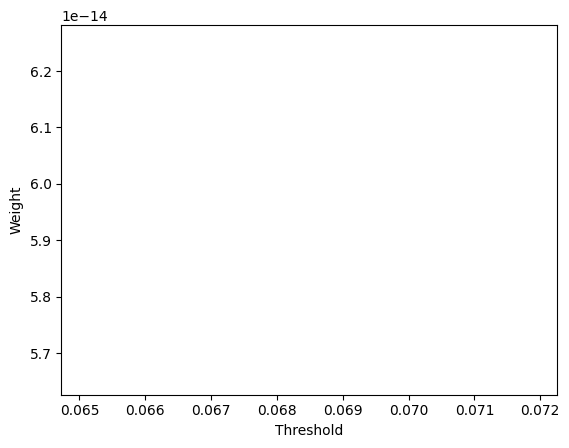

[0.15000000000000002] [3.069108345489908e-13]


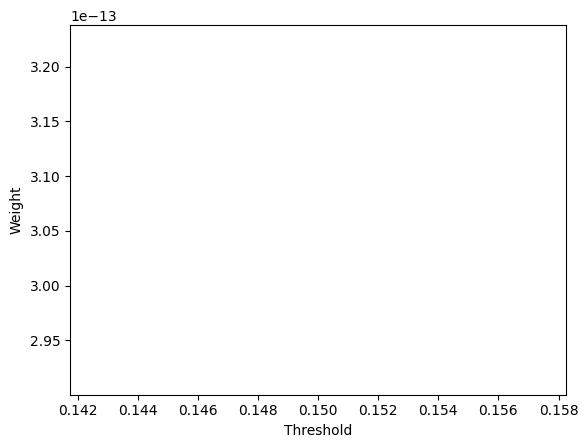

In [242]:
for predictor_variable, thresholds in soglie.items():

    sorted_soglie = sorted(list(zip(soglie[predictor_variable], omega_star[predictor_variable])), reverse=False)
    soglies = [v for (v, l) in sorted_soglie]
    omegas = [l for (v, l) in sorted_soglie]

    print(soglies, omegas)
    plt.step(soglies, omegas)
    plt.xlabel('Threshold')
    plt.ylabel('Weight')
    plt.show()
